# Data Generation and Analysis Workshop

## Monday October 7, 2024 - Getting Started (1/2) - Data Generation

**Objectives**: Learn how to use the time-domain simulation tools to generate a simple LDC-like dataset containing realistic instrumental noise and one MBHB signal.

In the course of this session we will:

1. Install the instrument simulator `LISA Instrument`, run a first simulation with default configuration and plot beatnote measurements.
3. Install the TDI package `PyTDI`, compute $X,Y,Z$ from beatnote measurements and plot $X,Y,Z$ in the time and frequency domains.
5. Compute the PSD using the Welch method, and discuss spectral estimation subtelties such as windowing, filtering, leakage.
6. Install the orbit simulator `LISA Orbits`, generate analytical equal-arm orbits, and plot the light travel times (LTTs).
7. Go back to `LISA Instrument`, set up a simulation with only laser, TM and OMS noise, and equal armelength orbits.
8. Install the `LDC` package and generate MBHB time-domain strain.
9. Install `LISA GW Response`, compute the link response.
10. Pass the resulting GW file to `LISA Instrument` to run a noise and signal instrument simulation, then evaluate TDI combinations via `PyTDI`.
10. Check the data against the noise model.

*Authors: E. Castelli, M. Le Jeune, J.B. Bayle*

### 0. Requirements
Import the required packages

In [1]:
# import system libraries
import logging
import sys

# import scientific libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
import h5py

Most simulation packages have a logging system. We recommend to enable it to get important warnings or progress information.

In [2]:
# set logging level to INFO (more verbose and informative)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

### 1. First basic simulation
Install `LISA Instrument`, the instrument simulator of the LISA Simulation Suite, and run a first simulation with default configuration.

#### 1.1 Install `LISA Instrument`
Start by installing `lisainstrument` via `pip`. Every LISA Simulation Suite package can be `pip` installed like this:

In [3]:
%pip install lisainstrument


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Import the `Instrument` class from the `lisainstrument` package.

An instance of this class represent a specific instrumental setup (noise parameters, instrumental assumptions such as orbits, injections, etc.), as well as simulation parameters (such as the sampling rate or the duration of the simulation).

In [4]:
from lisainstrument import Instrument

#### 1.2 Run first simulation with default configuration

By default, the simulation is performed with the following settings:

*   All instrumental noises are enabled with default values based on the perfomance model (warning: some noises are not up to date, or have simplified models)
* No GWs and no glitches
* No orbit file is used, armlengths are set to constant values based on a fit to Keplerian orbits
* Frequency offsets are set to constant values as well

✅ Instantiate an `Instrument` object with a `size` of  `simlen = 100000` samples. Let's call this instance of the `Instrument` class something easy to remember, like `instr`.

✅ Pass to the `instr` instance the keyword argument `lock = 'six'`, in order to set up the laser locking configuration to 6 lasers. We will talk more about laser locking in "Simulation in depth"; what you have to know is that by default, laser noises are correlated between different spacecraft and for a simple simulation, we don't want that (we want six uncorrelated laser noisetime series).

✅ Run a simulation with default parameters by running the `instr.simulate()` method of the `Instrument` class with no arguments.

✅ Write it to file with the `instr.write(path)` method.

In [6]:
# it's useful to set up the simulation length as a variable
# we'll access it throughout the entire notebook
simlen = 100000

# use this cell to comlpete your tasks
instr = Instrument(size=simlen, lock = "six")
instr.simulate()
instr.write("basic-simulation.h5")

INFO:lisainstrument.instrument:Initializing instrumental simulation
INFO:lisainstrument.instrument:Computing measurement time vector (size=100000, dt=0.25)
INFO:lisainstrument.instrument:Computing physics time vector (size=400000, dt=0.0625)
INFO:lisainstrument.instrument:Computing telemetry time vector (size=2, dt=86400.0)
INFO:lisainstrument.instrument:Using default set of static proper pseudo-ranges
INFO:lisainstrument.instrument:Using pre-defined locking configuration 'six'
INFO:lisainstrument.instrument:Designing antialiasing filter ('kaiser', 240, 1.1, 2.9)
INFO:lisainstrument.instrument:Starting simulation
INFO:lisainstrument.instrument:Generating clock noise
INFO:lisainstrument.instrument:Generating modulation noise
INFO:lisainstrument.instrument:Generating backlink noise
INFO:lisainstrument.instrument:Generating test-mass acceleration noise
INFO:lisainstrument.instrument:Generating ranging noise
INFO:lisainstrument.instrument:Generating OMS noise
INFO:lisainstrument.instrument

Simulation files are written to the [HDF5](https://docs.hdfgroup.org/hdf5/v1_14/_intro_h_d_f5.html) (Hierarchical Data Format) file format, designed to store and organize large amounts of data. Think of HDF5 data as a filesystem: datasets are organized in groups and subgroups, and metadata is stored in the form of user-defined, named attributes attached to groups and datasets.

Note also that the results of the simulation are also stored in memory. They can be accessed from the `instr` object (in addition to being readable from the HDF5 file).

Simulation parameters and metadata are also stored.

✅ Take a look at the simulation sampling rate and duration by accessing the `instr.fs`, `instr.duration` and `instr.central_freq` attributes. You can access all the simulation attributes in a similar way.

In [8]:
print(f'Sampling rate: {instr.fs} Hz')
print(f'Duration: {instr.duration} s')
print(f'Central frequency: {instr.central_freq} Hz')


Sampling rate: 4.0 Hz
Duration: 25000.0 s
Central frequency: 281600000000000.0 Hz


#### 1.3 Plot beatnotes

The main simulation results are the carrier interferometric beatnotes. One `Instrument` object provides three datasets for each beatnote:

* `fluctuations`, which are small in-band frequency fluctuations (~100 Hz),
* `offsets`, which are large, out-of-band frequency offsets (~10 MHz),
* `totals`, that is the sum of fluctuations and offsets (no subscript), which represents the instantaneous frequency of the beatnote.

Note that the division in fluctuations and offsets is entirely artificial. It allows simplified studies with higher numerical precision to, for example, study small noise residuals after TDI. In reality, we will only have access to the total frequency (or total phase) of the beatnotes.

LISA Instrument provides a number of convenient methods for plotting the different beatnote components: `instr.plot_fluctuations()`, `instr.plot_offsets()` and `instr.plot_totals()`.

✅ Use all three plotting methods for plotting and compare the results (pay attention to the amplitude of each plot).

⚠️ Remember to skip a few hundred samples at the beginning of the simulation by passing the keyword argument `skip = nsamples` to each function. This is because the simulation uses a number of digital filters, which need some warmup time (to reach the steady state). The first samples of a simulation are always invalid.

INFO:lisainstrument.instrument:Plotting beatnote frequency fluctuations


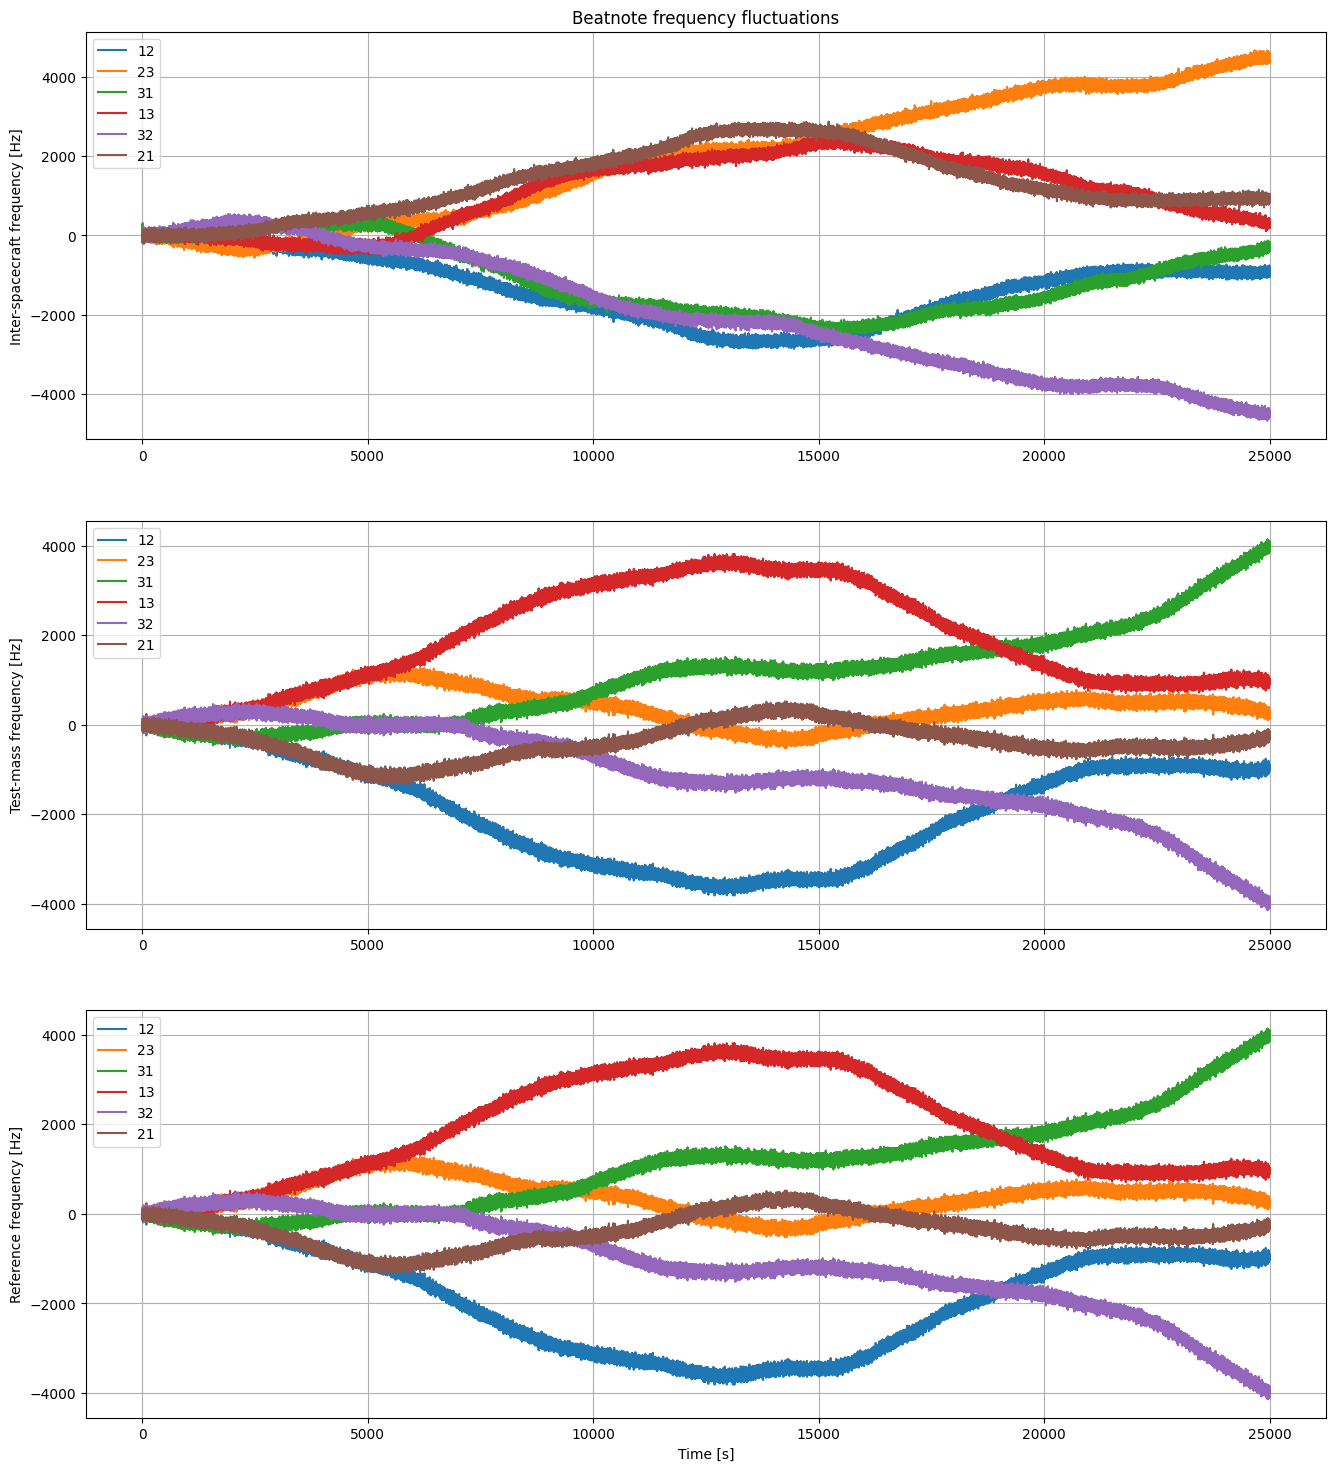

INFO:lisainstrument.instrument:Plotting beatnote frequency fluctuations


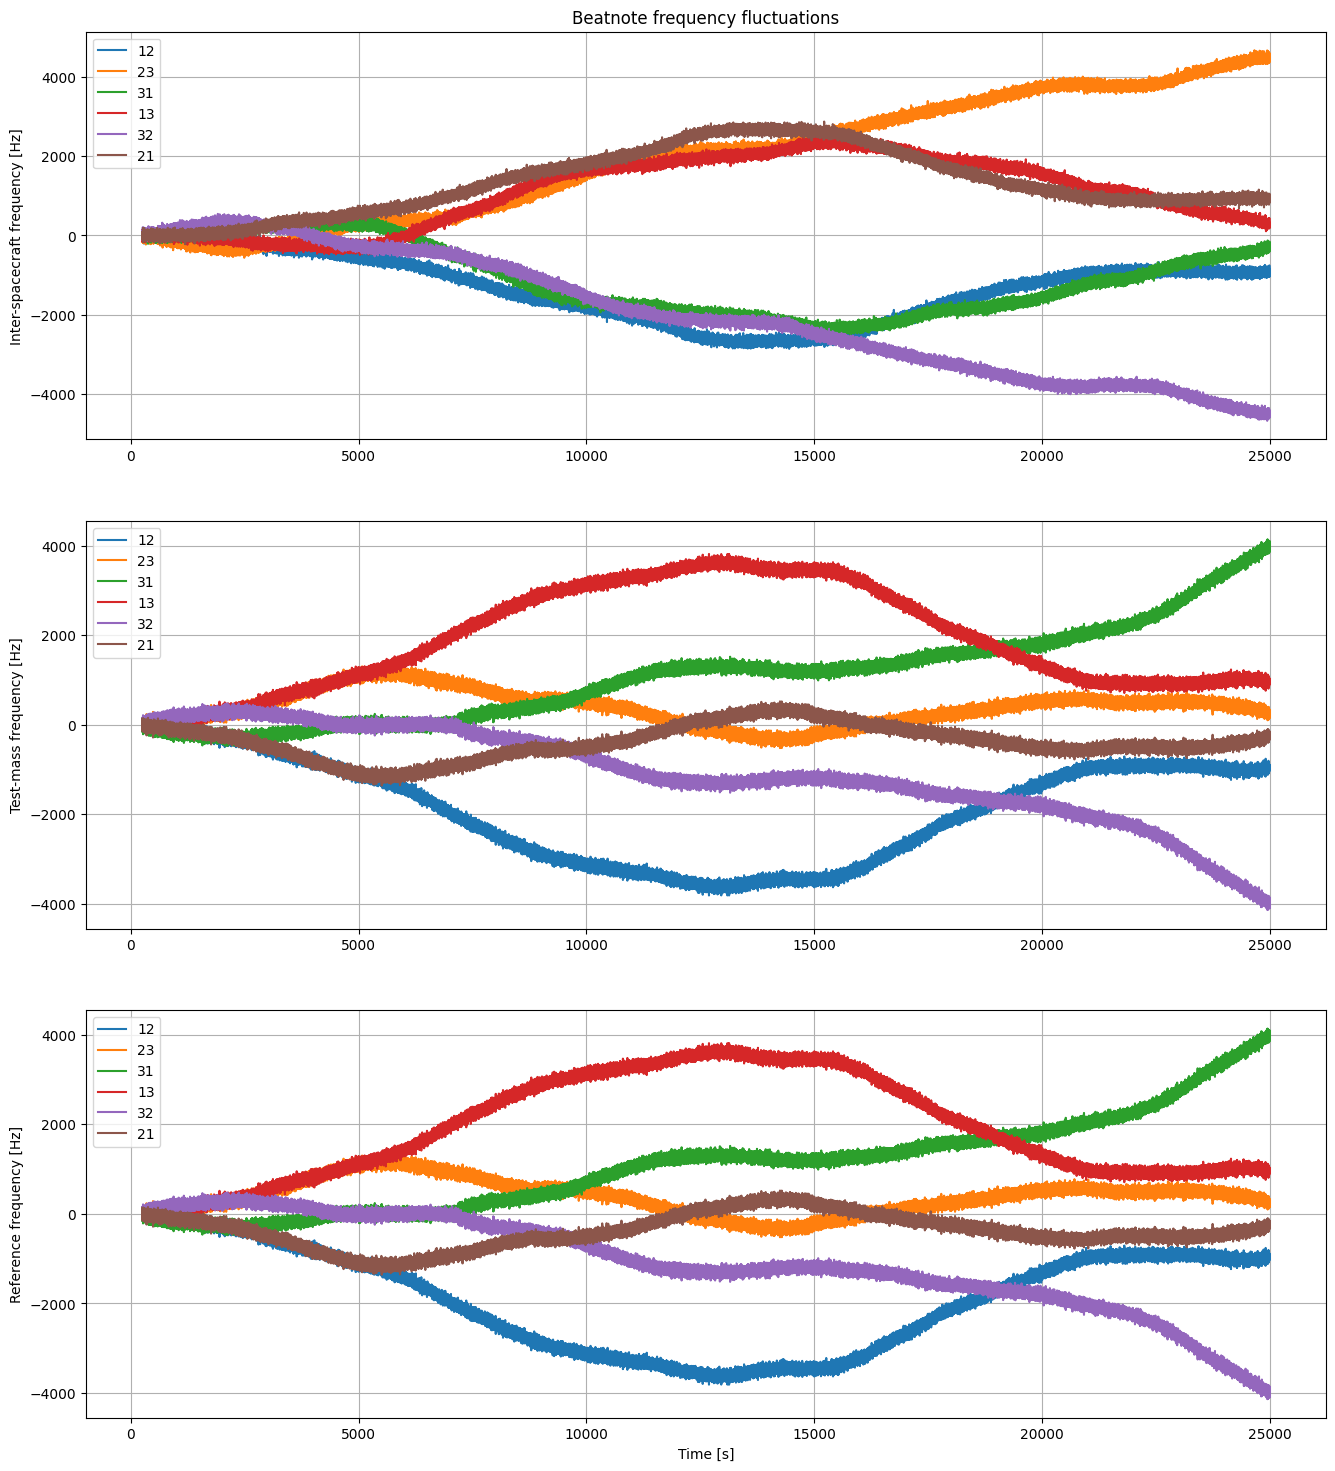

INFO:lisainstrument.instrument:Plotting beatnote frequency offsets


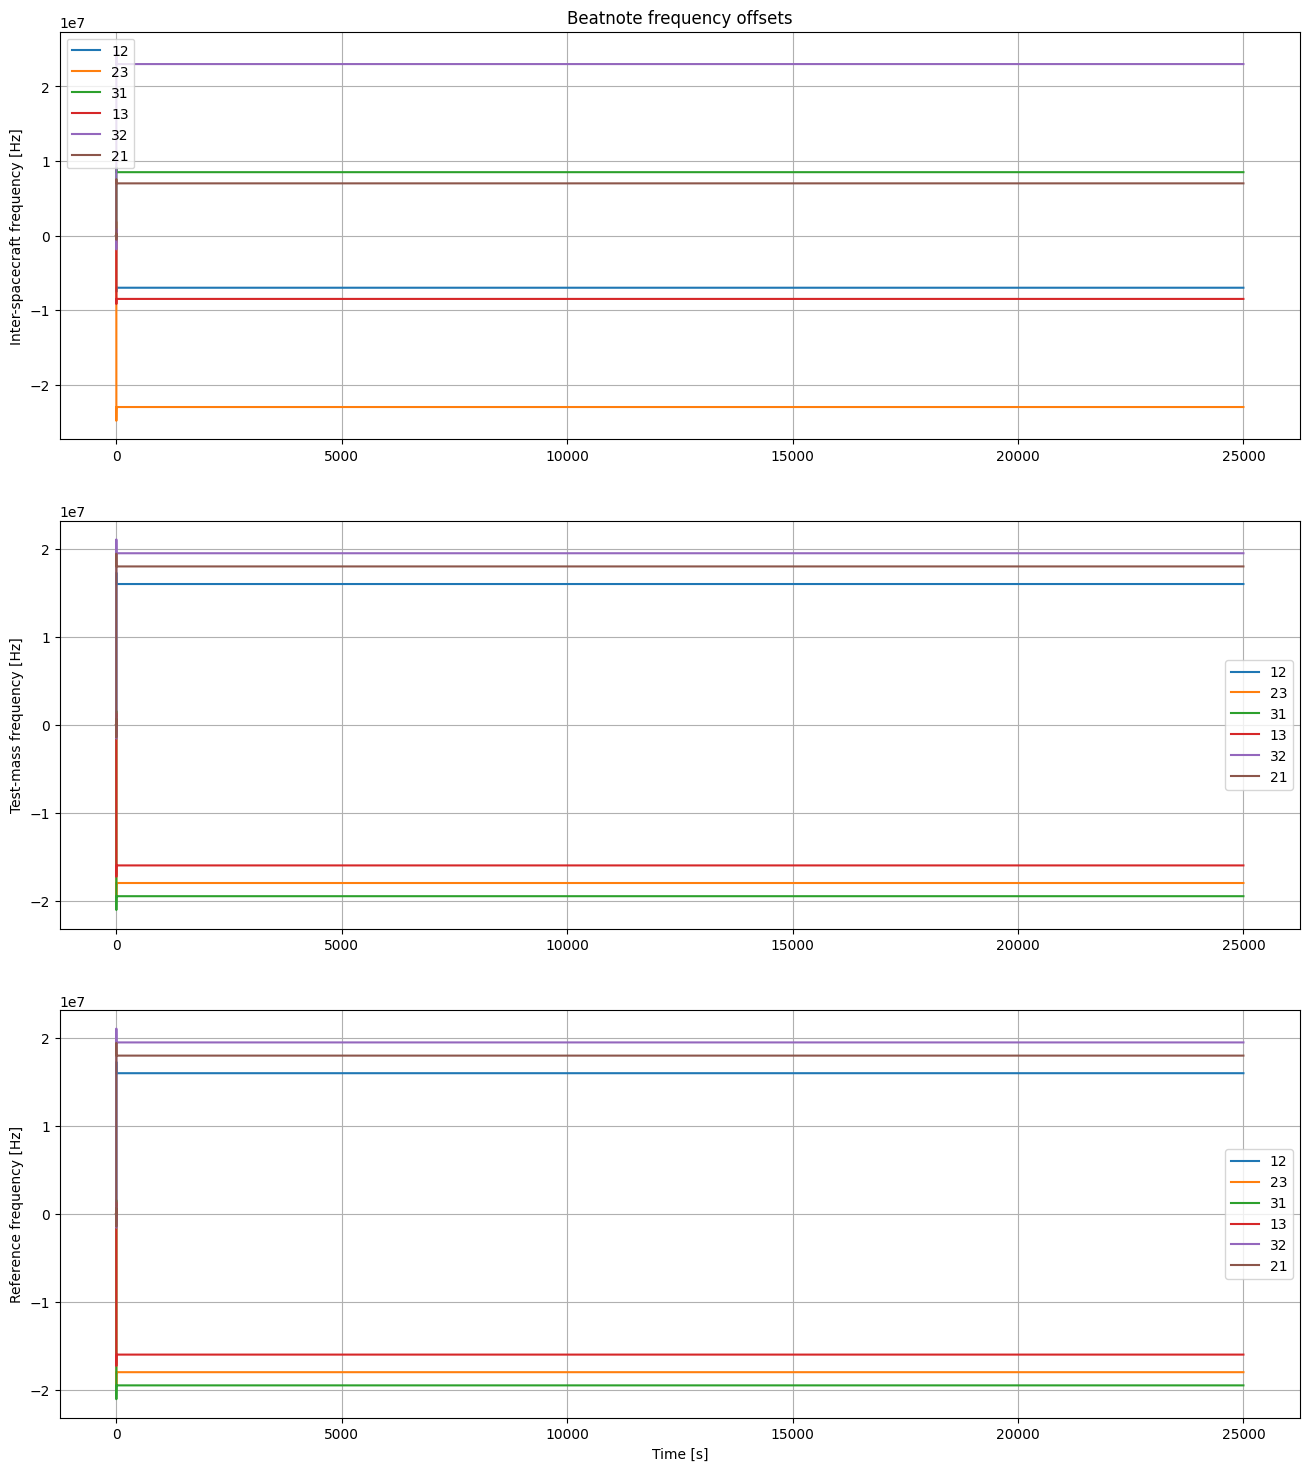

INFO:lisainstrument.instrument:Plotting beatnote frequency offsets


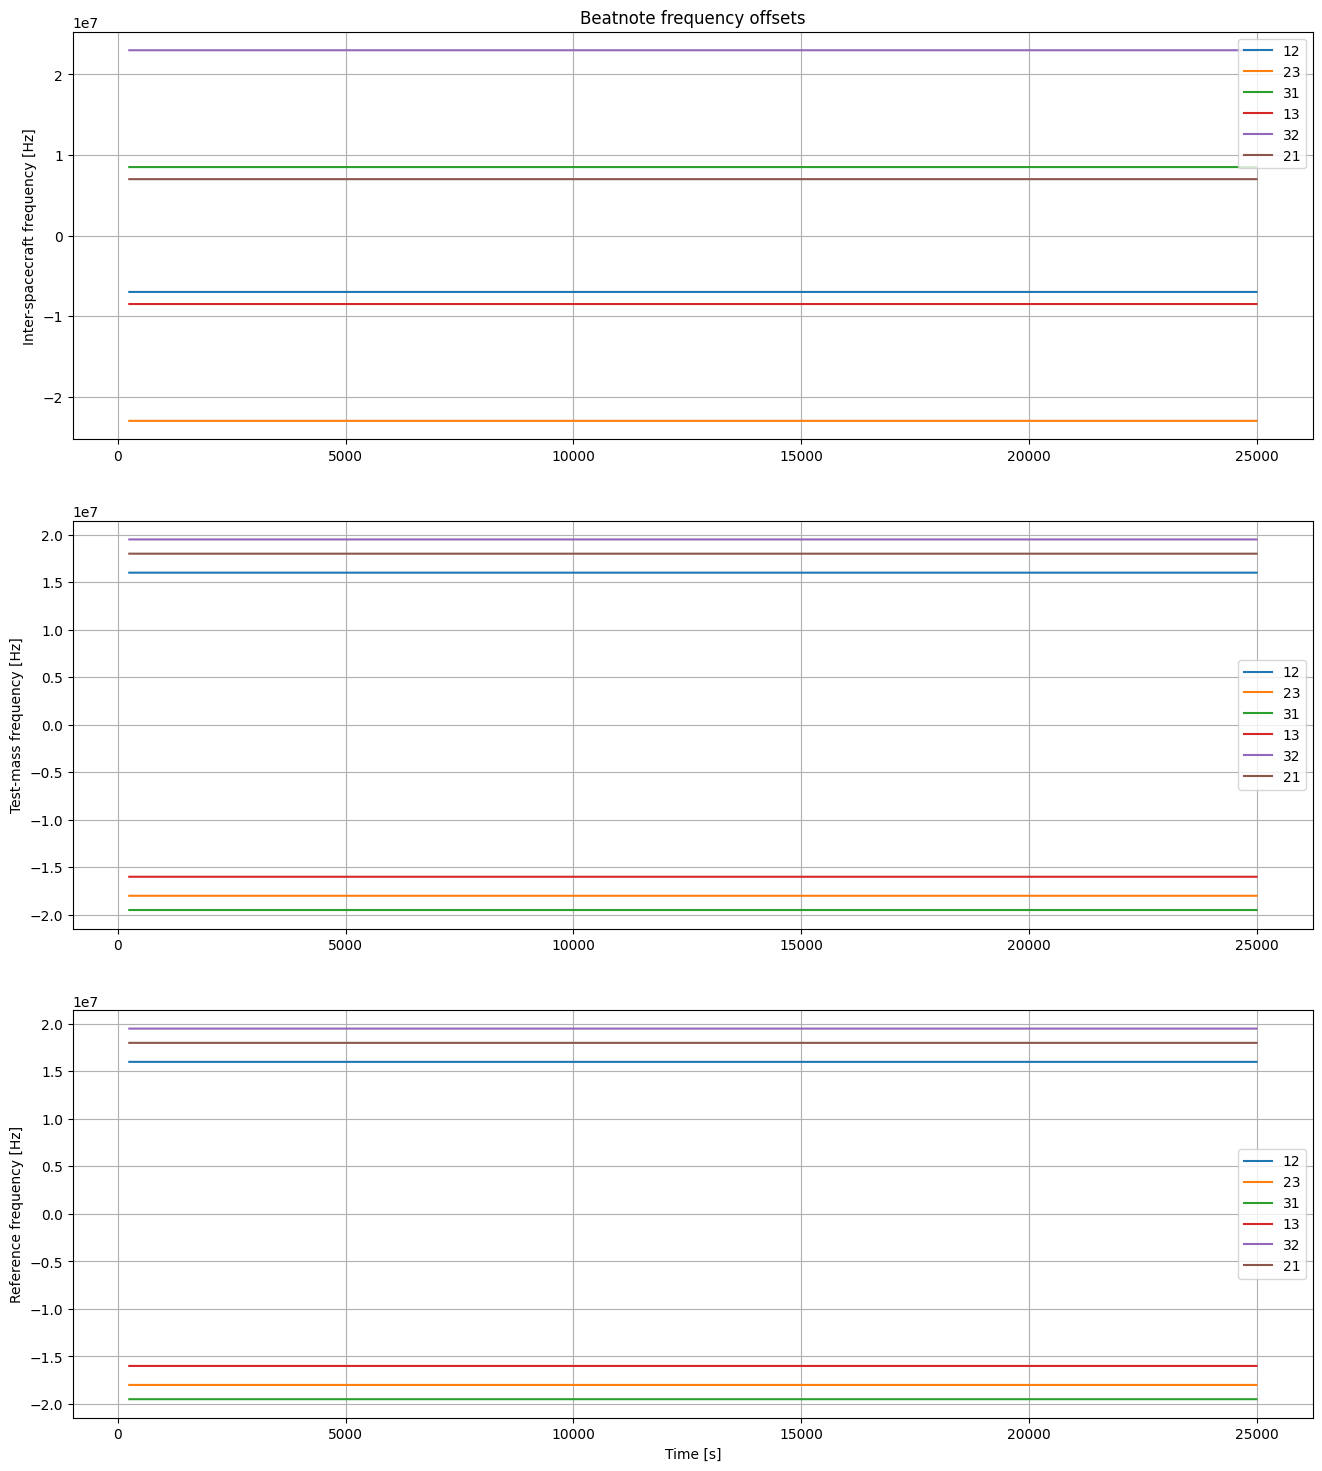

INFO:lisainstrument.instrument:Plotting beatnote total frequencies


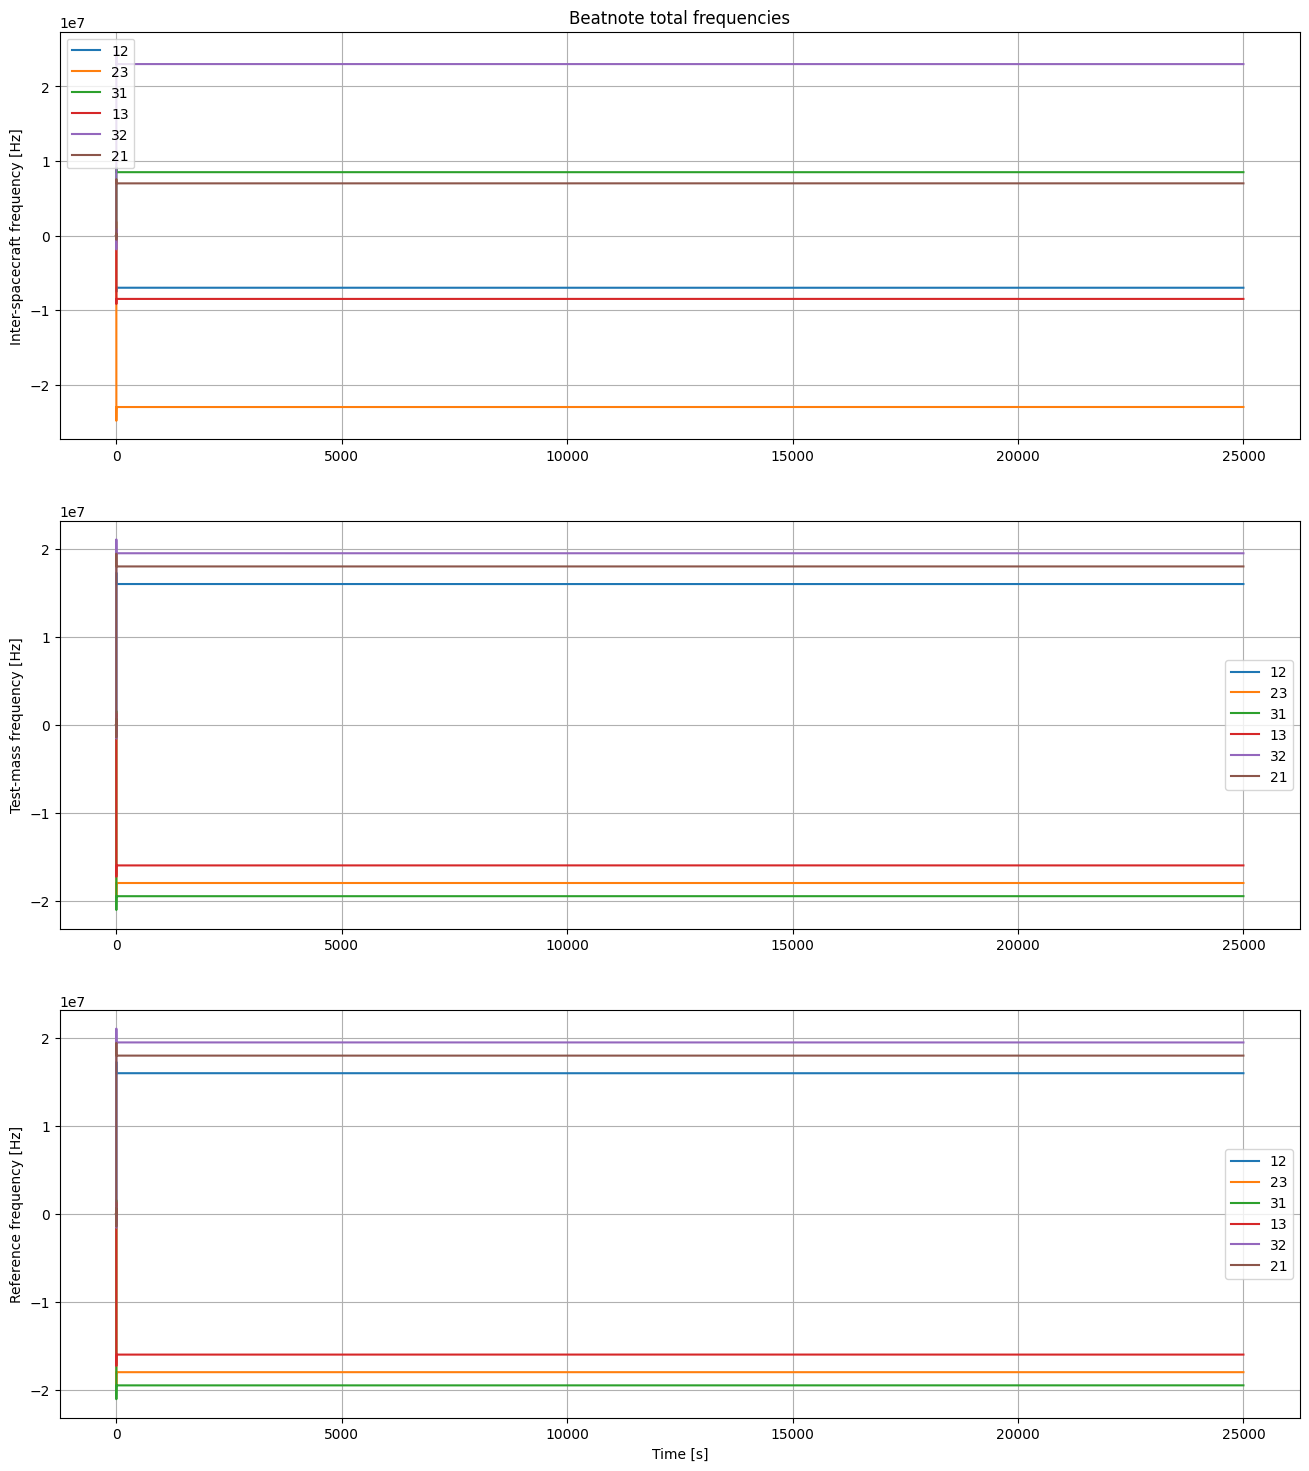

INFO:lisainstrument.instrument:Plotting beatnote total frequencies


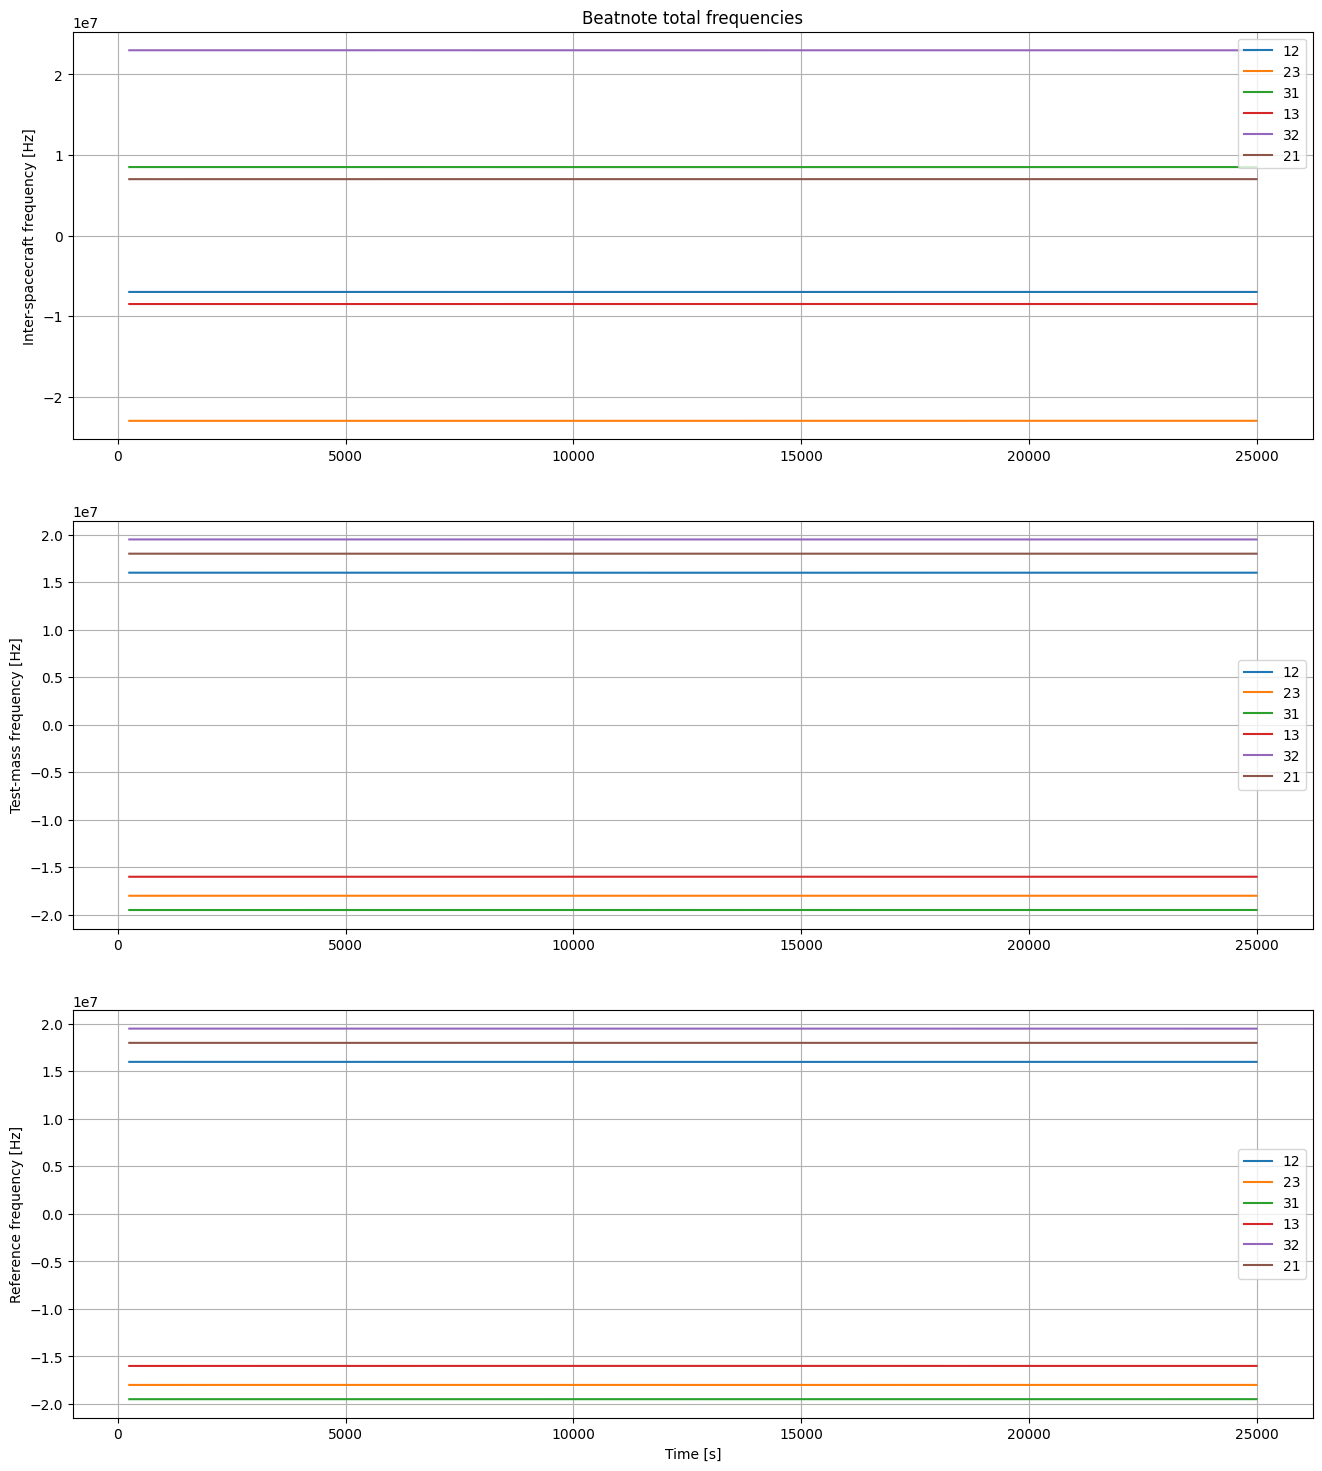

In [9]:
# Plot the different beatnote components
# Skip some samples to account for warm-up times of filters etc.
samples_to_skip = 1000

instr.plot_fluctuations()
instr.plot_fluctuations(skip=samples_to_skip)
instr.plot_offsets()
instr.plot_offsets(skip=samples_to_skip)
instr.plot_totals()
instr.plot_totals(skip=samples_to_skip)


### 2. Evaluate time-delay interferometry (TDI)

Install `PyTDI` and compute 2nd generation TDI combinations $X$,$Y$,$Z$ from beatnote measurements.

TDI is necessary to remove the overwhelming laser noise.

#### 2.1 Install `pytdi` via `pip`

In [10]:
%pip install pytdi


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### 2.2 Import relevant `pytdi` classes

📚 [`PyTDI` documentation is available here](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/).

From `pytdi` we import the `Data` class, needed to load the simulation data, and the TDI second generation Michelson combinations, X, Y and Z: they're named `X2`, `Y2`, `Z2` to distinguish them from the first generation Michelson combinations `X1`, `Y1`, `Z1`.

In [11]:
from pytdi import Data
from pytdi.michelson import X2, Y2, Z2

INFO:pytdi.core:Initializing combination with components '{'isi_12': [(1.0, [])], 'rfi_12': [(0.5, [])], 'rfi_21': [(0.5, ['D_12'])], 'tmi_12': [(-0.5, [])], 'tmi_21': [(-0.5, ['D_12'])]}'
INFO:pytdi.core:Rotating combination '<pytdi.core.LISATDICombination object at 0x7156d0b602e0>' by 120 degrees
INFO:pytdi.core:Transforming combination '<pytdi.core.LISATDICombination object at 0x7156d0b602e0>' with mapping '{1: 2, 2: 3, 3: 1}'
INFO:pytdi.core:Rotating combination '<pytdi.core.LISATDICombination object at 0x7156d0b60310>' by 120 degrees
INFO:pytdi.core:Transforming combination '<pytdi.core.LISATDICombination object at 0x7156d0b60310>' with mapping '{1: 2, 2: 3, 3: 1}'
INFO:pytdi.core:Reflecting combination '<pytdi.core.LISATDICombination object at 0x7156d0b602e0>' around '1'
INFO:pytdi.core:Transforming combination '<pytdi.core.LISATDICombination object at 0x7156d0b602e0>' with mapping '{1: 1, 2: 3, 3: 2}'
INFO:pytdi.core:Reflecting combination '<pytdi.core.LISATDICombination object 

#### 2.3 Compute X, Y, Z in the time domain

✅  Load the simulation data. This can be achieved by passing to the `Data.from_instrument()` method either a `lisainstrument.Instrument` object like the `instr` instance we created before, or a measurement HDF5 file produced with LISA Instrument and saved to disk, like the `basic-simulation.h5` file we just created.

```python
from pytdi import Data
from lisainstrument import Instrument

instru = Instrument(...)
instru.simulate()
data = Data.from_instrument(instru)
```
or
```python
from pytdi import Data
from lisainstrument import Instrument

instru = Instrument(...)
instru.simulate()
instr.write('measurements.h5', skipped=200)

data = Data.from_instrument('measurements.h5')
```

📚 [`Data.from_instrument()` documentation](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/quickstart.html#data-from-lisa-instrument)

In [14]:
# data = Data.from_instrument(...)
data = Data.from_instrument("basic-simulation.h5")
data.args

INFO:pytdi.interface:Loading measurement file 'basic-simulation.h5'
INFO:pytdi.interface:Initializing data object
INFO:pytdi.interface:Computing delay derivatives


{'delays': {'d_12': array([-8.70607663e-27, -9.41529412e-10,  3.98050550e-08, ...,
          8.31805043e+00,  8.31805029e+00,  8.31805015e+00]),
  'd_23': array([-8.67514822e-27, -9.38184693e-10,  3.96636492e-08, ...,
          8.32782358e+00,  8.32782382e+00,  8.32782408e+00]),
  'd_31': array([-8.70607666e-27, -9.41529365e-10,  3.98050537e-08, ...,
          8.32179637e+00,  8.32179626e+00,  8.32179616e+00]),
  'd_13': array([-8.70521054e-27, -9.41435746e-10,  3.98010950e-08, ...,
          8.34221794e+00,  8.34221804e+00,  8.34221814e+00]),
  'd_32': array([-8.67686793e-27, -9.38370554e-10,  3.96715085e-08, ...,
          8.27946828e+00,  8.27946804e+00,  8.27946780e+00]),
  'd_21': array([-8.70521052e-27, -9.41435816e-10,  3.98010970e-08, ...,
          8.34597216e+00,  8.34597230e+00,  8.34597244e+00])},
 'fs': np.float64(4.0),
 'delay_derivatives': {'d_12': array([-3.76611765e-09,  7.96101099e-08, -1.07046186e-06, ...,
         -5.87727435e-07, -5.69760704e-07, -5.62213550e-07]),

After loading the simulation data, we need to build  and evaluate the TDI combination.


📚 [Building and evaluating a TDI combination](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/quickstart.html#using-standard-combinations)

✅ Build each combination via the `X2.build()` method using `**data.args` as an argument, generating a callable object. The `build()` method works analogously for `Y2`, `Z2` and all the other TDI combinations.


In [15]:
# build the TDI combinations for X, Y and Z

X_built = X2.build(**data.args)
Y_built = Y2.build(**data.args)
Z_built = Z2.build(**data.args)

INFO:pytdi.core:Building combination '<pytdi.core.LISATDICombination object at 0x7156d08e2950>'
INFO:pytdi.core:Building combination '<pytdi.core.LISATDICombination object at 0x71567ab08790>'
INFO:pytdi.core:Building combination '<pytdi.core.LISATDICombination object at 0x7156d08e0070>'


✅ Evaluate the built combination on the dictionary of simulation measurement beatnotes contained in the `data` object: `data.measurements`.

✅ Remember to divide the final TDI combination by the LISA laser central frequency $f_\text{central} = 2.816 \times 10^{14}$ Hz to recover the adimensional (strain) TDI amplitude from the frequency-unit beatnotes. You can access this central frequency through your instrument instance `instr`.

In [21]:
# evaluate the TDI combination you just built on the measurement data
X = X_built(data.measurements) / instr.central_freq
Y = Y_built(data.measurements) / instr.central_freq
Z = Z_built(data.measurements) / instr.central_freq



INFO:pytdi.core:Evaluate combination '<pytdi.core.LISATDICombination object at 0x7156d08e2950>'
INFO:pytdi.core:Evaluate combination '<pytdi.core.LISATDICombination object at 0x71567ab08790>'
INFO:pytdi.core:Evaluate combination '<pytdi.core.LISATDICombination object at 0x7156d08e0070>'


✅ Plot the TDI combinations time-series. Remember to skip the same initial couple hundred samples, to avoid edge effects.

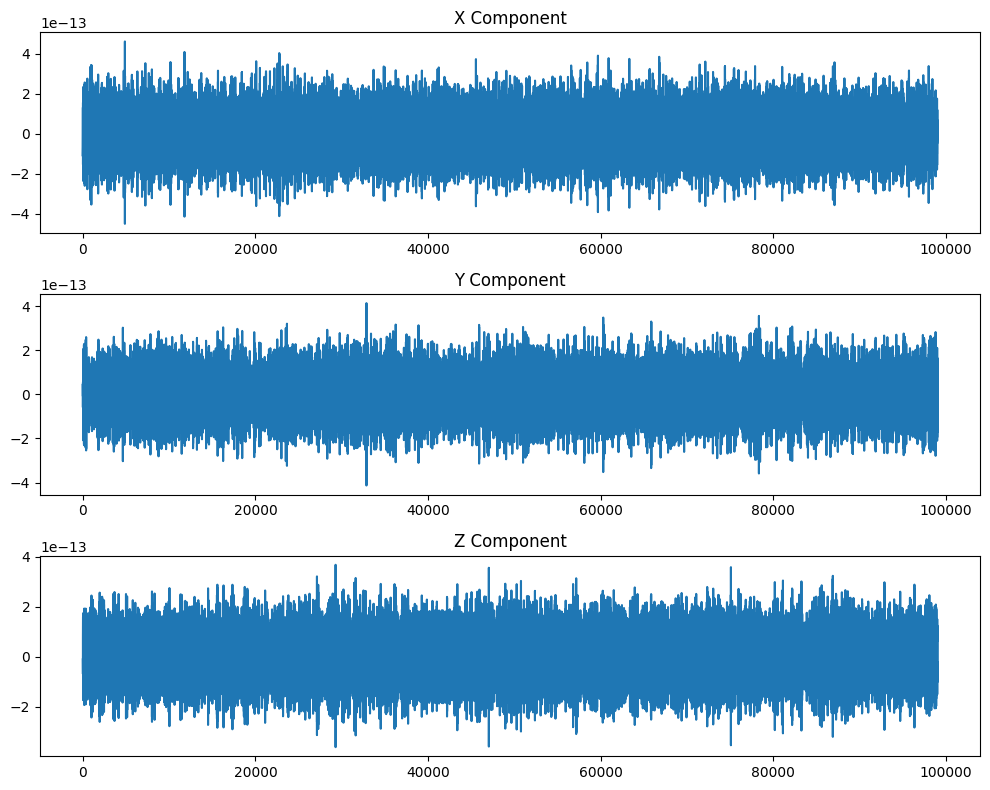

In [30]:
# plot here

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.plot(X[1000:])
plt.title('X Component')

plt.subplot(3, 1, 2)
plt.plot(Y[1000:])
plt.title('Y Component')

plt.subplot(3, 1, 3)
plt.plot(Z[1000:])
plt.title('Z Component')

plt.tight_layout()
plt.show()

Compute the Power Spectral Density (PSD), discuss spectral estimation, windowing, filtering, spectral leakage.


The Power Spectral Density (PSD) is the Fourier Transform of the autocorrelation of your signal, and it is numerically estimated via Discrete Fourier Transform methods.

We will be estimating the PSD via Welch periodogram method, implemented in `scipy.signal.welch`. The basic principle of the Welch method is to split your timeseries data into overlapping segments of length `nperseg`, apply a spectral window to each each segment, evaluate the periodogram of each segment and then average the result.

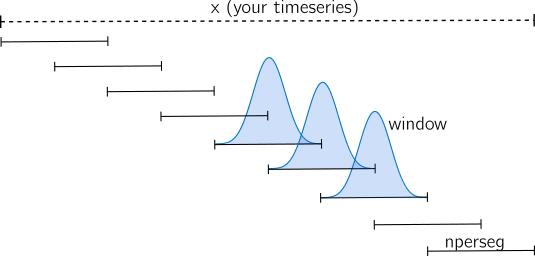


✅ Compute the PSD using `scipy.signal.welch` for all three TDI combinations.

📚 [`scipy.signal.welch` documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html)


*   ✅ Use the instrumental simulation sampling frequency `instr.fs`, and set the length of each averaging segment `nperseg` to the length of the TDI combination to use.

* ✅ Remember to skip the first few hundred samples of your data to avoid edge effects.

⚠️ Again, TDI combinations are computed from digital filters, which need to be initialized. Always trim initial TDI samples.




In [32]:
f, psd_X2 = scipy.signal.welch( X[1000:] ,
                               fs= instr.fs ,
                               nperseg= len(X[1000:])
                               )

f, psd_Y2 = scipy.signal.welch( Y[1000:],
                               fs= instr.fs ,
                               nperseg= len(Y[1000:])
                               )



f, psd_Z2 = scipy.signal.welch( Z[1000:],
                               fs= instr.fs ,
                               nperseg= len(Z[1000:])
                               )

Usually we prefer to deal with the square root of the PSD, the Amplitude Spectral Density (ASD).

✅ Plot the ASDs of TDI combinations $X, Y, Z$ using the `plt.loglog()` method.

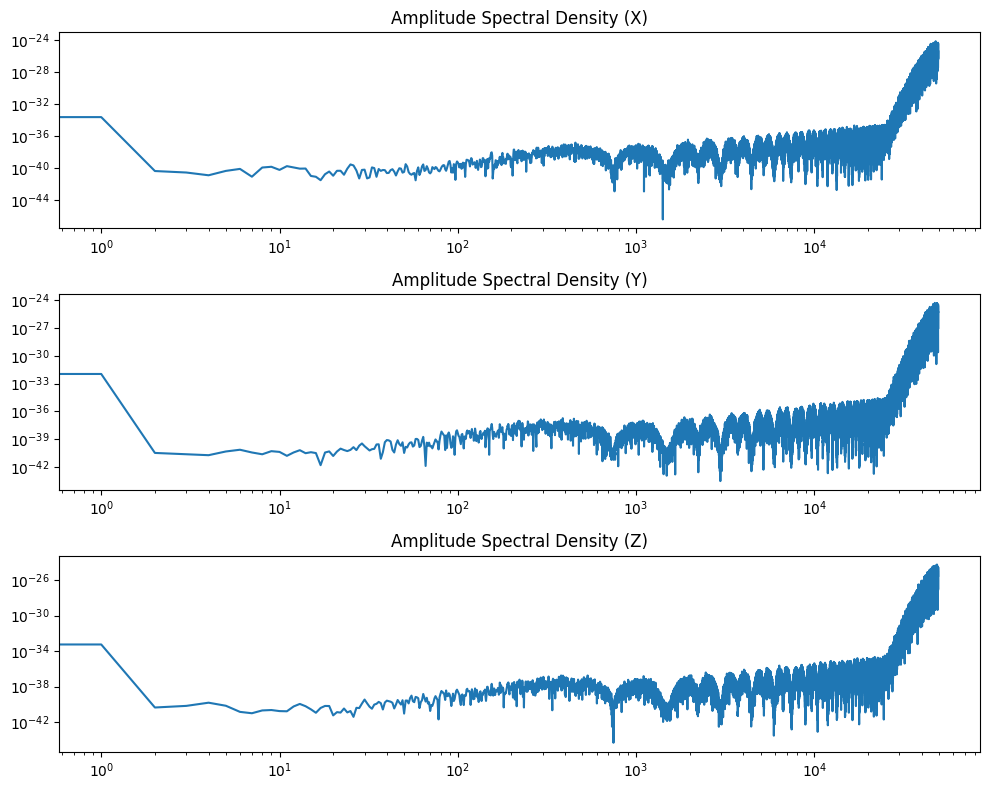

In [ ]:
# plot here

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.loglog(psd_X2)
plt.title('Amplitude Spectral Density (X)')

plt.subplot(3, 1, 2)
plt.loglog(psd_Y2)
plt.title('Amplitude Spectral Density (Y)')

plt.subplot(3, 1, 3)
plt.loglog(psd_Z2)
plt.title('Amplitude Spectral Density (Z)')

plt.tight_layout()
plt.show()

The default spectral window used by the `scipy.signal.welch()` method is `window='hann'`. Spectral leakage can be suppressed via adequate spectral windows, depending on your needs.

✅ Plot the PSD of X, Y and Z again by providing different `window` options to `scipy.signal.welch()`:

*   First try the `'boxcar'` window. What do you see?
*   Then try the `'blackman'` window. How is it different from the previous cases?



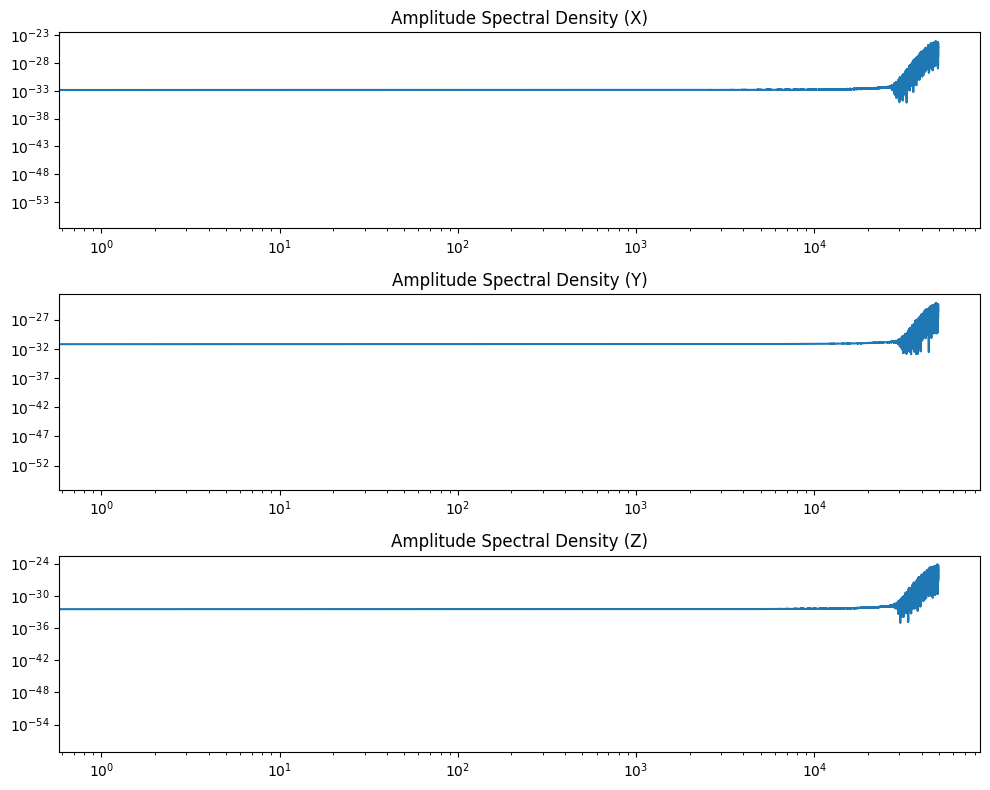

In [36]:
# evaluate and plot here
f, psd_X2 = scipy.signal.welch( X[1000:] ,
                               fs= instr.fs ,
                               nperseg= len(X[1000:]),
                               window= 'boxcar'
                               )

f, psd_Y2 = scipy.signal.welch( Y[1000:],
                               fs= instr.fs ,
                               nperseg= len(Y[1000:]),
                               window= 'boxcar'
                               )



f, psd_Z2 = scipy.signal.welch( Z[1000:],
                               fs= instr.fs ,
                               nperseg= len(Z[1000:]),
                               window= 'boxcar'
                               )

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.loglog(psd_X2)
plt.title('Amplitude Spectral Density (X)')

plt.subplot(3, 1, 2)
plt.loglog(psd_Y2)
plt.title('Amplitude Spectral Density (Y)')

plt.subplot(3, 1, 3)
plt.loglog(psd_Z2)
plt.title('Amplitude Spectral Density (Z)')

plt.tight_layout()
plt.show()

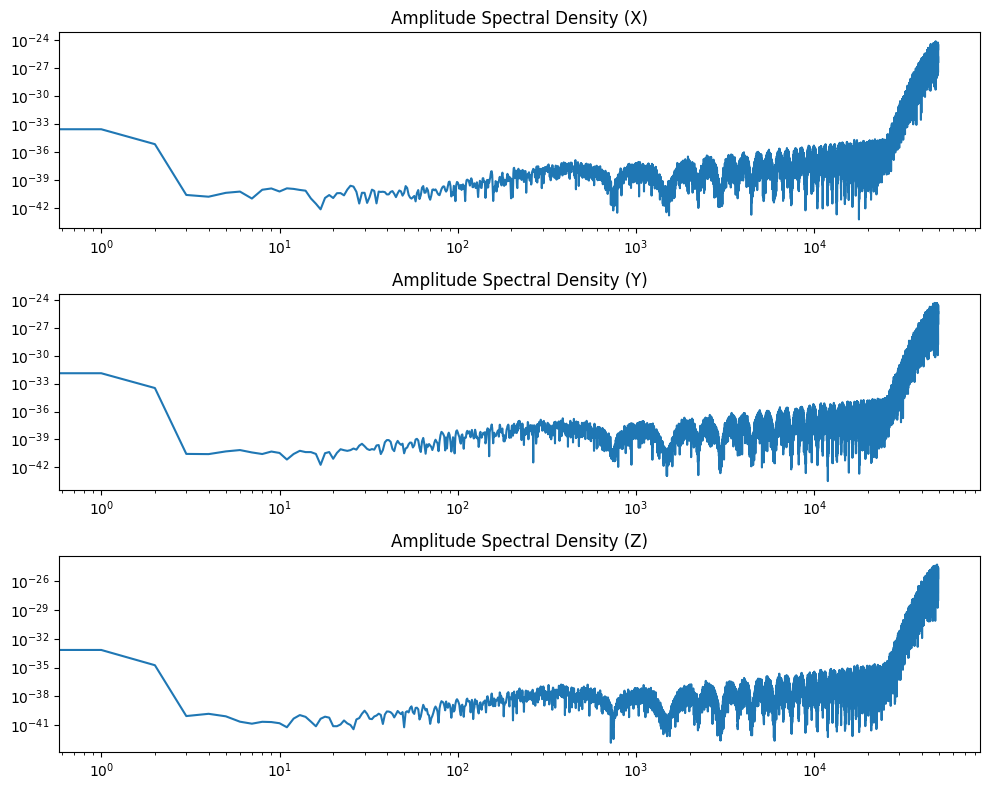

In [37]:
# evaluate and plot here
f, psd_X2 = scipy.signal.welch( X[1000:] ,
                               fs= instr.fs ,
                               nperseg= len(X[1000:]),
                               window= 'blackman'
                               )

f, psd_Y2 = scipy.signal.welch( Y[1000:],
                               fs= instr.fs ,
                               nperseg= len(Y[1000:]),
                               window= 'blackman'
                               )



f, psd_Z2 = scipy.signal.welch( Z[1000:],
                               fs= instr.fs ,
                               nperseg= len(Z[1000:]),
                               window= 'blackman'
                               )

plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.loglog(psd_X2)
plt.title('Amplitude Spectral Density (X)')

plt.subplot(3, 1, 2)
plt.loglog(psd_Y2)
plt.title('Amplitude Spectral Density (Y)')

plt.subplot(3, 1, 3)
plt.loglog(psd_Z2)
plt.title('Amplitude Spectral Density (Z)')

plt.tight_layout()
plt.show()

### 3. Add the LISA orbits
Install `LISA Orbits`, generate equal-arm orbits, plot light travel times (LTTs)


#### 3.1 Install `lisaorbits` via `pip`

In [ ]:
%pip install lisaorbits

By default, LISA Instrument uses a very simple model with static PPRs. More realistic orbits are provided as orbit files computed by LISA Orbits.

📚 Go to https://gitlab.in2p3.fr/lisa-simulation/orbits/-/releases to access automatically generated orbit files from the latest released version of LISA Orbits (v1.0.2).

In this version, three sets of files are available:

* Equal armlength orbits
* Keplerian orbits
* ESA orbits

📚 [LISA Orbits documentation](https://lisa-simulation.pages.in2p3.fr/orbits/htlm/latest/index.html).

We will use the `EqualArmlengthOrbits`, which are computed assuming that LISA has equal laser armlengths.



In [ ]:
from lisaorbits import EqualArmlengthOrbits

#### 3.2 Generate Equal Arm orbits

✅ Create an instance of `EqualArmlengthOrbits()` and call it something easy to remember, like `orbits`

✅ Write it to file using the `orbits.write(path)` method.



In [ ]:
# orbits here

#### 3.3 Plot the orbits light travel times (LTTs)

✅ Plot the orbits instance using the `orbits.plot_links(t)` method. Remember to choose an appropriate time vector `t`: you can access the instrumental simulation time vector via `instr.t`

In [ ]:
# plot orbits here

### 4. Run slightly more complex simulation

Go back to `LISA Instrument`, set up a simulation with only laser, TM and OMS noise, fixed

#### 4.1 Tuning parameters of the simulation

Most simulation parameters, such as noise levels, path to external files, etc., can be set as optional arguments when instantiating the `Instrument`object.

⚠️ To use the orbit file, just pass the path to your orbit file as the `orbits` argument to an `Instrument` object. By default, LISA Instrument then loads the proper pseudo ranges and their derivatives (`ppr` and `d_ppr` datasets), which are the appropriate delays and delay derivatives to relate the different spacecraft proper times.

✅ Instantiate a new `Instrument` object and pass it the orbit file `orbits = 'orbits.h5'`.
* ✅ pass to the `instr` instance the keyword argument `lock = 'six'`, in order to set up the laser locking configuration to 6 lasers.

In [ ]:
# instantiate instrument object here


In addition, LISA Instrument contains a number of convenience function to disable all noise sources of a common group after the Instrument has been instantiated:

* `instru.disable_clock_noises()` disables all instrumental clock imperfections
* `instru.disable_pathlength_noises()` disables all OMS, TM and backlink noises
* `instru.disable_ranging_noises()` disables ranging noise in the mprs (note: clock_noise will still appear in the mprs unless explicitly disabled as well).
* `instru.disable_jitters()` disables all spacecraft angular jitters

Note that not all noises fall in these four groups, such that calling these four functions will not disable all noises. This can be achieved with a dedicated function `instru.disable_all_noises()`, which has an optional argument to keep only a single group of noises enabled.

⚠️ **Syntax change from previous versions**
* For example, `instru.disable_all_noises(excluding='laser')` disables all noises except laser frequency noise.  All of these functions are defined in the file `instrument.py`. When in doubt, take a look inside to check which noises are turned off by each of them!

Note that LISA Instrument is written in such a way that disabling noises completely bypasses their generation, drastically improving execution speed. This can be very convenient for quick, simple studies.

**Lets run another simulation, just as we did in section 1.2**

✅ Disable all noises apart for `'laser'`, `'test-mass'` and `'oms'` noise

✅ Run the simulation

✅ Write it to file

✅ Plot the beatnote fluctuations

#### 4.2 Load the LISA noise model and compare it to the simulation

Install the LISA Data Challenge `LDC` package and load the LISA noise model

In [ ]:
# requirements for the lisa-data-challenge package
!apt-get install libgsl-dev
!apt-get install libfftw3-dev
# LDC package
%pip install lisa-data-challenge

Documentation:

* 📚 LDC software documentation can be found [here](https://lisa.pages.in2p3.fr/LDC/).
* 📚 LDC convention and data documentation can be found [here](https://lisa-ldc.lal.in2p3.fr/)

Let's import the `ldc` module to get the LISA noise model.

In [ ]:
# import noise model from the LDC?
from ldc.lisa.noise import get_noise_model

✅ Generate the TDI LISA noise model from the LDC method `get_noise_model(model (str), freqs (array))` with `model` set to `'sangria'` and the same frequency vector obtained from the `scipy.signal.welch` evaluation of the TDI noise spectra.

📚 [Documentation for `get_noise_model()`](https://lisa.pages.in2p3.fr/LDC/lisa.html#ldc.lisa.noise.noise.get_noise_model)

In [ ]:
LISAnoisemodel = get_noise_model('sangria', f)

✅ Evaluate the noise model PSD. The output of `get_noise_model()` is an `AnalyticNoise` object. To evaluate the PSD, you can call the `.psd()` method with the following args and kwargs:
```
AnalyticNoise.psd(f, option="X", tdi2=True, equal_arms=True)
```
* `option="X"` holds for TDI combinations $X$, $Y$ and $Z$
* `tdi2=True` needs to be specified because the default ooption is `False`
* `equal_arms=True` is the default option, and it holds in our case because we are using `EqualArmlengthOrbits`

In [ ]:
# LISAnoisepsd = LISAnoisemodel.psd(
#
#                                   )

✅ Load the data using the `pytdi` method `Data.from_Instrument(path)`.

✅ Build and evaluate the TDI response to the noise simulation. Label the $X, Y, Z$ combinations evaluated here with `_noise` or an analogous label (we'll need these later!)

In [ ]:
# give noise file to pytdi


In [ ]:
# plot

In [ ]:
# evaluate PSD with welch

In [ ]:
# plot

### 5. Add Gravitational Waves


#### 5.1 Generate the GW strain
Use the `LDC` package to generate MBHB time-domain strain: import the `ldc` module to generate the gravitational wave waveform ($h_+,h_\times$) `HpHc`.

In [ ]:
from ldc.waveform.waveform import HpHc

Let's define a dictionary of the Massive Black Hole Binary parameters we'll use to generate the GW strain. These parameters come from a MBHB source injected in the LDC *Sangria* dataset.

In [ ]:
pMBHB = {'EclipticLatitude': -0.30300442294174235,
 'EclipticLongitude': 1.2925183861048521,
 'PolarAngleOfSpin1': 1.2031361791056812,
 'PolarAngleOfSpin2': 2.097303543065685,
 'Spin1': 0.747377,
 'Spin2': 0.8388,
 'Mass1': 1323277.47932,
 'Mass2': 612485.5060299999,
 'CoalescenceTime': 11526944.921879262,
 'PhaseAtCoalescence': 1.2201968860015653,
 'InitialPolarAngleL': 2.6919824500032945,
 'InitialAzimuthalAngleL': 1.808398497592109,
 'Redshift': 1.73941,
 'Distance': 13449.011,
 'ObservationDuration': 31558149.763545603,
 'Cadence': 3.0}

Look at the below code snippet example from the `HpHc` documentation linked here:

📚 [Documentation for `HpHc`](https://lisa.pages.in2p3.fr/LDC/waveform.html#module-ldc.waveform.waveform.hphc)

```python
>>> HpHc = HpHc.type("demo", "GB", "None"):
>>> HpHc.set_param(pGB)
>>> HpHc.display()

Source parameters:
Amplitude : 1.07345e-22  [ 1 ]
EclipticLatitude : 0.312414  [ rad ]
EclipticLongitude : -2.75291  [ rad ]
Frequency : 0.00135962  [ Hz ]
FrequencyDerivative : 8.94581279e-19  [ Hz2 ]
Inclination : 0.523599  [ rad ]
InitialPhase : 3.0581565  [ rad ]
Polarization : 3.5621656  [ rad ]
Internal parameters:
- cos(inc)  = 0.8660252915835662 rad
```

The `hphc` instance can be declared with the `HpHc.type(source_name, source_type, approximant)` method:
* `source_name (str)` is the name you give to the source
* `source_type (str)` is the type of source you want to declare: it can be `MBHB`, `SBHB`, `GB`, `SOBHB` or `EMRI`
* `approximant (str)` is the waveform approximant used here: it can be `IMRPhenomD` for the BHB classes and it can be `AK` or `FSEF` for EMRIs.

Compute the waveform ($h_+,h_\times$) with the LDC package:

✅ Create an instance of `HpHc` using `HpHc.type()`, with an MBHB source with the IMRPhenomD approximant

✅ Use the `HpHc.set_param()` method to set the MBHB parameters `pMBHB`

✅ Create a time vector array `t` of appropriate length (hint: set it from `0` to some time after the MBHB `CoalescenceTime`)

✅ Compute the time-domain ($h_+,h_\times$) using method `_, _ = hphc.compute_hphc_td(t)` to get two separate `hp`, `hc` objects



In [ ]:
# hphc = HpHc.type(..., ..., ...)

# hphc.set_param(pMBHB)

# dt = 0.25
# t = np.arange(... , ..., dt)

# hp, hc = hphc.compute_hphc_td(t)

✅ Plot the $h_+, h_\times$ strain timeseries `hp`, `hc`. Limit th plot to the last 100000 samples of the array (we're only interested in the final part of the merger)

#### 5.2 Evaluate the GW response
Install `LISA GW Response`, compute link response, pass it to `Instrument`, then `PyTDI`

In [ ]:
%pip install lisagwresponse

##### ⚠️ **!! Important note about data generation and data size when evaluating the LISA GW response**

When generating the LISA response to a GW strain, we have to take into account orbits and GW strain *longer* than the stretch of time we're interested in.

To evaluate the response between time $t_0$ and $t_{max}$ we need to have
- orbit information at $t_0 - T$ (with $T = 8.3$ s light travel time between two spacecraft)
- strain information up to $t_0 - T - \frac{1 \mathrm{AU}}{c}$ in the past, depending on the projection $\vec{k} \cdot \vec{x}$ between the source wave vector $\vec{k}$ and the spacecraft position $\vec{x}$
- strain information up to $t_\text{max} + \frac{1 \mathrm{AU}}{c}$ in the future, again depending on the projection $\vec{k} \cdot \vec{x}$ between the source wave vector $\vec{k}$ and the spacecraft position $\vec{x}$

Because of this, we will evaluate the GW response on a shorter timescale than the $h_+, h_\times$ strain computed above. We will focus on the final stretch of the $h_+, h_\times$ strain timeseries to make sure we include the MBHB merger in the response.

In [ ]:
from lisagwresponse import ReadStrain

Import the `ReadStrain` class to read the strain timeseries we created with the LDC package.

📚 [Documentation for `ReadStrain()`](https://lisa-simulation.pages.in2p3.fr/gw-response/latest/read.html#readstrain)

✅ Create a new time vector `t_sim` that slices the last `simlen = 100000` samples of the time vector `t` used to compute `hphc`



In [ ]:
# t_sim = t[-simlen:]

✅ Create an instance of the `ReadStrain` class with a name easy to remember (like `strain`) by passing it the following arguments
* the time vector `t_sim`
* the $h_+, h_\times$ timeseries `hp`, `hc` (remember to slice them appropriately to the last `simlen` samples t0 match the time vector!)
* the sky localization parameters `gw_beta` and `gw_lambda` from the MBHB parameter dictionary `pMBHB`
* the orbit file `orbits`

In [ ]:
# strain = ReadStrain(
#                     )

✅ Plot the gravitational wave response strain using the `strain.plot(t)` method with the time vector `t_sim`

✅ Write the GW response to the strain to file using the `strain.write(path, **kwargs)` method, passing the following arguments and keyword arguments to the function:


*   the path of the `.h5` file you want to write the response to
*   time information extracted from the `t_sim` array: `t0`, `dt`, `size`. Hint: use the first element of `t_sim` as `t0` and the length of `t_sim` as `size`.



#### 5.3 Add the GW to the simulation
To add the GW response to the simulation we have a few different paths in front of us:
1. we can pass the GW response file we just generated to the `Instrument` instance as an external file, and run the instrumental simulation again

or

2. we can evaluate the TDI response to the GW response file alone and add it to the noise TDI response we evaluated previously in section 4.2

Let's do both!


##### 5.3.1 Pass the GW file to `Instrument`

✅ Pass the GW response `.h5` file to the `Instrument` instance as a keyword argument `gws` in addition to the `orbits` keyword argument.
* ✅ Now we also need to pass to the `Instrument` instance the right `t0` for the simulation: use the same `t0` we set for the GW response!

✅ As we did before, disable all noises using `instr.disable_all_noises()` with the `excluding` keyword argument, and exclude `'laser'`, `'test-mass'`, `'oms'`

✅ Run the instrumental simulation again

✅ Write it to file

✅ Load the simulation data using the `pytdi` method `Data.from_instrument()` we used above

✅ Build and evaluate the TDI combinations using the `.build` methods we used above

✅ Plot the TDI $X, Y, Z$ time-series

##### 5.3.2 Evaluate TDI response and add it to the instrument TDI response

✅ Load the GW response file using the `pytdi` method `Data.from_gws()`: to run this method you have to pass it the GW response file AND the orbit file as arguments.

📚 [Documentation for `from_gws()`](https://lisa.pages.in2p3.fr/LDPG/wg6_inrep/pytdi/master/interface.html#pytdi.Data.from_gws)

✅ Build and evaluate the TDI response for $X, Y, Z$ to the GW response file. Label the $X, Y, Z$ combinations evaluated here with `_gw` or an analogous label (we'll need to sum them to the `_noise` TDI combinations we generated earlier)

🚨 When importing data with the `Data.from_gws()` method you *don't* need to divide the TDI combinations by the central frequency of the laser

✅ Sum the TDI combinations for the GW response `_gw` to the TDI combinations for the noise simulation `_noise`

✅ Plot the results for one exemplifying TDI combination (either $X, Y$ or $Z$)


### 6. Check noise models against data

✅ Plot the PSD of the TDI data against the LISA instrumental noise model for the simulated data above (instrumental simulation, GW simulation, instrumental + gw simulation)

#### 7. Write the TDI combinations to disk

✅ Use `h5py.File(path, 'w')` to write the TDI combinations $X, Y, Z$ for the complete simulation (including noise and GW response) to disk.
- Use method `.create_dataset(dataset_name, data)` to create one dataset for each TDI combination and write the TDI data to that dataset.

📚 [Documentation for `h5py.File()`](https://docs.h5py.org/en/stable/high/file.html)

In [ ]:
# Saving TDI 2.0 data
# path = 'simulation-noise-gws-tdi2.h5'

# hdf5 = h5py.File(path, 'w')

# hdf5.create_dataset('X', data=X)
# same for Y
# same for Z
# # Closing file
# hdf5.close()

In [ ]:
# Saving TDI 2.0 data
# path = 'simulation-gws-tdi2.h5'
